# Solving a QUBO using QOAO ansatz in qiskit

In [1]:
import sys
sys.path.append('../')
from src.sharedstate import SharedState
from src.qubo import Qubo

In [2]:
# SharedState does all the file loading
ss = SharedState()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from SharedState.
q = Qubo(ss)

In [81]:
from qiskit_algorithms.utils import algorithm_globals

# for reproducable results
algorithm_globals.random_seed = 3

qubo, ising_ham = q.qubo_hamiltonian_pairs[1] # use the first slice as an example to solve

In [82]:
#QAOA approach

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator, Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')


In [92]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(ising_ham, reps=2)
# Draw
#ansatz.decompose(reps=3).draw("mpl")
def cost_func(params, ansatz, ising_ham, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, ising_ham, parameter_values=params).result().values[0]
    return cost


estimator = Estimator(options={"shots": int(1e3)})
sampler = Sampler(options={"shots": int(1e3)})

In [93]:
beta  = [0.7977, 0.7905]#, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765, 0.1634]#, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
x0 = beta+gamma
#x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
res = minimize(cost_func, x0, args=(ansatz, ising_ham, estimator), method="SLSQP")
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.39378578497643246
       x: [-6.596e+04 -3.251e+04  4.864e+04  9.652e+03]
     nit: 21
     jac: [-6.294e+05 -1.102e+06 -1.337e+06 -1.564e+06]
    nfev: 315
    njev: 21

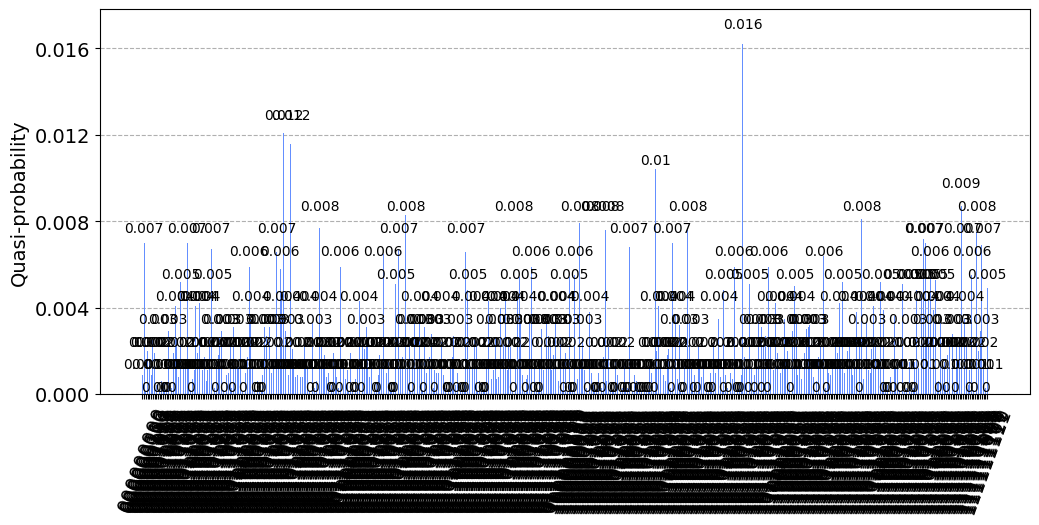

In [94]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

plot_distribution(samp_dist.binary_probabilities(), figsize=(12, 5))

In [95]:
# classical brute-force solution
sol, ref_value = q.find_optimum(qubo=qubo)
sol, ref_value

([0, 1, 0, 0, 0, 0, 0, 0, 1], -0.05676551209085727)

In [96]:
samp_dist_binary={}
for key in samp_dist.keys():
    samp_dist_binary[tuple(q._bitfield(key, len(qubo)))]=samp_dist[key]

solutions_list=[]
for key in samp_dist_binary.keys():
    solutions_list.append([key, samp_dist_binary[key], q.ising_energy(key, qubo)])

In [97]:
import pandas as pd
solutions_df=pd.DataFrame(solutions_list, columns=['bitstring', 'probability', 'energy'])

solutions_df.sort_values(['energy'])[:50]

,bitstring,probability,energy
123,"(0, 1, 0, 0, 0, 0, 0, 0, 1)",0.0005,-0.056766
249,"(1, 0, 0, 0, 0, 0, 0, 0, 1)",0.0005,-0.048348
126,"(0, 1, 0, 0, 0, 0, 1, 0, 0)",0.0043,-0.047478
30,"(0, 0, 0, 1, 0, 0, 0, 0, 1)",0.0011,-0.046959
124,"(0, 1, 0, 0, 0, 0, 0, 1, 0)",0.0007,-0.043368
60,"(0, 0, 1, 0, 0, 0, 0, 0, 1)",0.0010,-0.042785
59,"(0, 0, 1, 0, 0, 0, 0, 0, 0)",0.0024,-0.041677
13,"(0, 0, 0, 0, 1, 0, 0, 0, 0)",0.0005,-0.039374
33,"(0, 0, 0, 1, 0, 0, 1, 0, 0)",0.0042,-0.039046
1,"(0, 0, 0, 0, 0, 0, 0, 1, 0)",0.0070,-0.037979
